# Back-to-back regression
An quick-and-dirty implementation based on King, J. R., Charton, F., Lopez-Paz, D., & Oquab, M. (2020). Back-to-Back Regression: Disentangling the Influence of Correlated Factors from Multivariate Observations. NeuroImage, 117028.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin

Let's define some data:

In [6]:
T = 300  # number of time points
P = 10  # number of predictors
K = 100  # number of voxels
X = np.random.normal(0, 1, size=(T, P))
β = np.random.normal(0, 1, size=(P, K))
ϵ = np.random.normal(0, 5, size=(T, K))
Y = X @ β + ϵ

And the back-to-back regression model and, for comparison, a vanilla encoding model:

In [7]:
class B2b(BaseEstimator, RegressorMixin):
    """ Back-to-back regression model. """
    def __init__(self, λx=1, λy=1):
        self.λx = λx
        self.λy = λy
    
    def fit(self, X, Y):
        Ix = np.eye(P)
        Iy = np.eye(K)
        Ĝ = inv(Y.T @ Y + self.λy * Iy) @ Y.T @ X
        Ĥ = inv(X.T @ X + self.λx * Ix) @ X.T @ Y @ Ĝ
        self.Ŝ = np.diag(np.diag(Ĥ))
        XŜ = X @ self.Ŝ
        self.Ŵ = inv(XŜ.T @ XŜ) @ XŜ.T @ Y
        return self
    
    def predict(self, X):
        return X @ self.Ŝ @ self.Ŵ
    

class Enc(BaseEstimator, RegressorMixin):
    """ Vanilla 'encoding' regression model. """
    def __init__(self, λx=1):
        self.λx = λx
    
    def fit(self, X, Y):
        Ix = np.eye(P)
        self.β̂ = inv(X.T @ X + self.λx * Ix) @ X.T @ Y
        return self
    
    def predict(self, X):
        return X @ self.β̂

And let's do some tests:

In [8]:
n_splits = 10
cv = ShuffleSplit(n_splits=n_splits, train_size=0.9, test_size=0.1)

# model (b2b, enc) x n_splits x voxels
r2 = np.zeros((2, n_splits, K))

# Initialize models
b2b = B2b()
enc = Enc()

# Cross-validated analysis
for i, (train_idx, test_idx) in enumerate(cv.split(X, Y)):
    Ŷ = b2b.fit(X[train_idx], Y[train_idx]).predict(X[test_idx])
    r2[0, i, :] = r2_score(Y[test_idx], Ŷ, multioutput='raw_values')
    Ŷ = enc.fit(X[train_idx], Y[train_idx]).predict(X[test_idx])
    r2[1, i, :] = r2_score(Y[test_idx], Ŷ, multioutput='raw_values')

Not much of a difference (see plots below)?

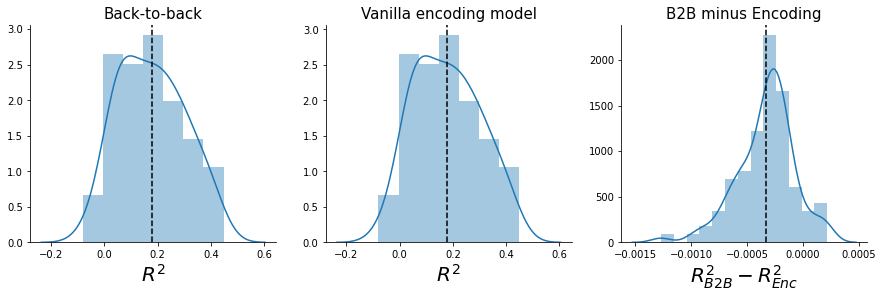

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

sns.distplot(r2[0, :, :].mean(axis=0), ax=axes[0])
axes[0].axvline(r2[0, :, :].mean(), ls='--', c='k')

sns.distplot(r2[1, :, :].mean(axis=0), ax=axes[1])
axes[1].axvline(r2[1, :, :].mean(), ls='--', c='k')

r2_diff = r2[0, :, :].mean(axis=0) - r2[1, :, :].mean(axis=0)
sns.distplot(r2_diff, ax=axes[2])
axes[2].axvline(r2_diff.mean(), ls='--', c='k')

titles = ['Back-to-back', 'Vanilla encoding model', 'B2B minus Encoding']
for i, title in enumerate(titles):
    axes[i].set_title(title, fontsize=15)
    if i < 2:
        axes[i].set_xlabel(r"$R^2$", fontsize=20)
    else:
        axes[i].set_xlabel(r"$R^2_{B2B} - R^2_{Enc}$", fontsize=20)

sns.despine()